<a href="https://colab.research.google.com/github/electricshadok/notebooks/blob/main/vae_toy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Variational Autoencoder (VAE)

This notebook demonstrates how to build and train a **Variational Autoencoder (VAE)** to learn and generate a simple 2D distribution.

**Implemented Features:**  
- **VAE with KL Annealing** to improve training stability.  

**Ideas for Further Experimentation:**  
- Experiment with **Mixture of Gaussians** instead of a standard isotropic Gaussian in the latent space.  
- Introduce **learnable per-feature weights** in the latent space to improve flexibility.  

**Improvement:**  
- The generation of new samples is not great yet and need improvement ❌

## Packages

In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

## 1. Generate Synthetic Data

We create a dataset of 2D points sampled from a Gaussian Mixture Model (GMM). This simulates data from a real-world distribution that we want the VAE to learn.

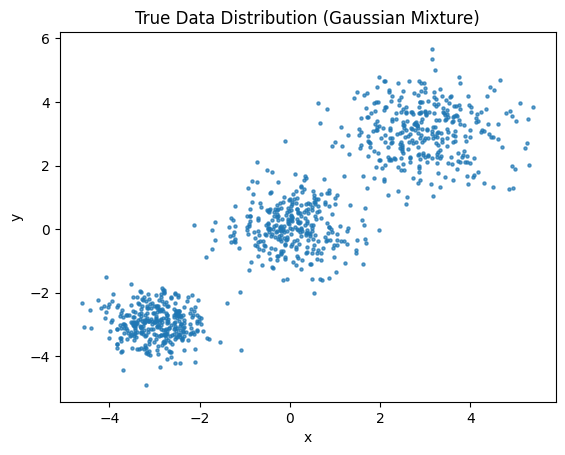

In [18]:
NUM_POINTS = 1000  # Total number of points
SEED = 42  # Seed for reproducibility

# Create synthetic data: Gaussian mixture
def sample_gaussian_mixture(n_samples, means, covs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    n_components = len(means)
    samples = []
    for _ in range(n_samples):
        k = np.random.choice(n_components)  # Randomly select one Gaussian component
        sample = np.random.multivariate_normal(means[k], covs[k])
        samples.append(sample)
    return np.array(samples)

# Parameters of the Gaussian mixture
means = [[0, 0], [3, 3], [-3, -3]]
covs = [np.eye(2) * 0.5, np.eye(2) * 0.8, np.eye(2) * 0.3]

# Generate data
X = sample_gaussian_mixture(NUM_POINTS, means, covs, seed=SEED)

# Visualize the synthetic data
plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.7)
plt.title("True Data Distribution (Gaussian Mixture)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 2. Variational autoencoder (VAE)

A Variational Autoencoder (VAE) consists of three main components:

1. **Encoder**: Compresses input data into a lower-dimensional latent space.
2. **Latent Space Representation**: The encoder predicts a **mean** and **standard deviation** for each latent dimension.
3. **Decoder**: Reconstructs the original input from the latent space representation.

In a Variational Autoencoder (VAE), we do not directly sample from the latent space. Instead, the encoder predicts a **mean** ( $\mu$ ) and **log-variance** ( $\log \sigma^2$) for each latent dimension. This allows the model to learn a structured and continuous latent space.

However, sampling directly from a normal distribution during training would make the model **non-differentiable**, preventing backpropagation.

To solve this, we use the **Reparameterization Trick**, which expresses the random sampling operation in a way that allows gradients to flow through:

$$z = \mu + \sigma \cdot \epsilon$$

where:
- $\mu$ is the predicted mean of the latent distribution.
- $\sigma = \exp(0.5 \cdot \log \sigma^2)$ is the standard deviation.
- $\epsilon \sim N(0, I)$ is a random noise sample from a standard normal distribution.

This trick allows the model to learn meaningful representations while still enabling **gradient-based optimization**.


We actually predict the log-variance $\log \sigma^2$ not the standard deviation $\sigma$ to ensure stability.

In [19]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )

        # Latent space (mean and log-variance)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  # Mean of latent space
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # Log-variance of latent space

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )


    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Reparameterization trick: z = mu + std * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Random noise
        z = mu + std * eps

        # Decode
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


input_dim = 2  # Data is 2D
latent_dim = 2  # Latent space is also 2D
hidden_dim = 16

X_tensor = torch.tensor(X, dtype=torch.float32)
vae = VAE(input_dim, latent_dim, hidden_dim)

x_recon, mu, logvar = vae(X_tensor)

print(f"Input : {X_tensor.shape}")
print(f"Output : {x_recon.shape}")
print(f"Latent mean : {mu.shape}")
print(f"Latent std : {logvar.shape}")

Input : torch.Size([1000, 2])
Output : torch.Size([1000, 2])
Latent mean : torch.Size([1000, 2])
Latent std : torch.Size([1000, 2])


## 3. Losses

The loss consists of two parts:

A Variational Autoencoder (VAE) optimizes two losses simultaneously:  

1. **Reconstruction Loss** measures how accurately the decoder can reconstruct the original input.  
   - It ensures that the generated output ( $\hat{x}$ ) is as close as possible to the original input \( x \).  
   - Mathematically, for continuous data, it is often computed using **Mean Squared Error (MSE)**:  

$$L_{\text{recon}} = \frac{1}{N} \sum_{i=1}^{N} || x_i - \hat{x}_i ||^2$$

2. **KL Divergence Loss** forces the latent space to follow a standard normal distribution ( $N(0, I)$), ensuring smooth and meaningful latent representations.  
   - Instead of allowing the encoder to map each input to any arbitrary point, this term encourages the latent variables \( z \) to be normally distributed.  
   - It is computed as:  

$$L_{\text{KL}} = -\frac{1}{2} \sum_{j=1}^{d} \left(1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2 \right)$$


The final **VAE loss** is the sum of these two terms, with an optional weighting factor \( \beta \) (used in **β-VAE**):

$$L = L_{\text{recon}} + \beta \cdot L_{\text{KL}}$$

where $\beta$ controls the importance of the KL divergence term.

In [20]:
def vae_loss(x, x_recon, mu, logvar, beta=1.0):
    # Note: We assume equal weighting for all features in the latent space,
    # meaning each feature contributes equally to the reconstruction loss.
    # TODO: Extend this by introducing learnable per-feature weights.

    # Reconstruction loss (MSE)
    recon_loss = nn.MSELoss(reduction='mean')(x_recon, x)

    # KL divergence: D_KL(q(z|x) || p(z))
    # Encourages the latent space to follow a standard normal distribution
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= x.size(0)  # Average over batch

    total_loss = recon_loss + kl_div * beta
    return total_loss, recon_loss.item(), kl_div.item()

# Compute loss
x_recon, mu, logvar = vae(X_tensor)
total_loss, recon_loss, kl_loss = vae_loss(X_tensor, x_recon, mu, logvar)
print(f"Total Loss : {total_loss}")
print(f"Reconstruction Loss : {recon_loss}")
print(f"KL Loss : {kl_loss}")


Total Loss : 7.013029098510742
Reconstruction Loss : 6.492203235626221
KL Loss : 0.5208258628845215


## 4. KL Annealing

**KL Annealing** is a technique used to stabilize the training of Variational Autoencoders (VAEs). A common problem in VAE training is that:
- The **reconstruction loss dominates**, causing the model to ignore the latent space (posterior collapse).
- The **KL divergence is too large**, preventing meaningful reconstructions.

KL Annealing **gradually increases** the weight of the KL divergence term ($\beta$) over training, allowing the model to **first focus on reconstruction** and then progressively enforce a structured latent space.


To implement KL annealing, we modify $\beta$ over epochs using a schedule:

Common **annealing schedules**:
1. **Linear Annealing**:  gradually increase to 1
2. **Stepwise Annealing**: staircase increase
3. **Exponential Annealing**: fast rise, then smooth


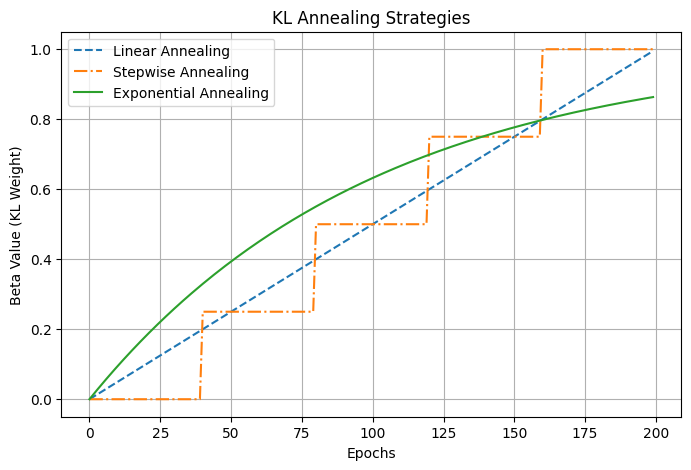

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Define different KL annealing strategies
linear_annealing = lambda t, T: min(1, t / T)
exponential_annealing = lambda t, T, k=0.01: 1 - np.exp(-k * t)

# Stepwise annealing: increases in discrete steps
def stepwise_annealing(t, T, steps=5):
    step_size = T // steps  # Divide into equal step intervals
    return min(1, (t // step_size) / (steps - 1))

# Generate values for visualization
epochs = np.arange(0, 200)  # Simulate 200 epochs
linear_values = [linear_annealing(e, 200) for e in epochs]
stepwise_values = [stepwise_annealing(e, 200) for e in epochs]
exp_values = [exponential_annealing(e, 200) for e in epochs]

# Plot the different annealing strategies
plt.figure(figsize=(8, 5))
plt.plot(epochs, linear_values, label="Linear Annealing", linestyle='dashed')
plt.plot(epochs, stepwise_values, label="Stepwise Annealing", linestyle='dashdot')
plt.plot(epochs, exp_values, label="Exponential Annealing", linestyle='solid')

plt.xlabel("Epochs")
plt.ylabel("Beta Value (KL Weight)")
plt.title("KL Annealing Strategies")
plt.legend()
plt.grid(True)
plt.show()


## 5. Training

Let's train the VAE using the **reconstruction loss** and **KL divergence loss**.

**Expected Results During Training** 🚀
- **Reconstruction Loss**:  
  - Should steadily **decrease** as the decoder improves at reconstructing inputs.
  - Eventually, it should stabilize once the model reaches an optimal balance.
  
- **KL Divergence**:  
  - Initially **low**, since the model prioritizes reconstruction.
  - Gradually **increases** as KL annealing encourages a structured latent space.
  - Should eventually stabilize once the encoder learns a meaningful distribution.


In [22]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 1000
KL_SCALE = 0.02

# Initialize VAE and optimizer
vae = VAE(input_dim, latent_dim, hidden_dim)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(X_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Training the VAE
loss_history = []

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Progress"):
    total_loss = 0
    total_recon_loss = 0
    total_kl_loss = 0

    # Compute dynamic KL weight
    beta = stepwise_annealing(epoch, NUM_EPOCHS) * KL_SCALE

    for batch in dataloader:
        x_batch = batch[0]

        # Forward pass
        x_recon, mu, logvar = vae(x_batch)

        # Compute loss using the updated vae_loss function
        loss, recon_loss, kl_loss = vae_loss(x_batch, x_recon, mu, logvar, beta)

        total_loss += loss.item()
        total_recon_loss += recon_loss
        total_kl_loss += kl_loss

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_history.append(total_loss / len(dataloader))

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] | Total Loss: {total_loss:.4f} | Recon Loss: {total_recon_loss:.4f} | KL Loss: {total_kl_loss:.4f} | Beta : {beta}")


Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [0/1000] | Total Loss: 215.3332 | Recon Loss: 215.3332 | KL Loss: 20.5692 | Beta : 0.0
Epoch [100/1000] | Total Loss: 0.0828 | Recon Loss: 0.0828 | KL Loss: 795.5093 | Beta : 0.0
Epoch [200/1000] | Total Loss: 4.2230 | Recon Loss: 0.0272 | KL Loss: 839.1496 | Beta : 0.005
Epoch [300/1000] | Total Loss: 1.1831 | Recon Loss: 0.1721 | KL Loss: 202.2035 | Beta : 0.005
Epoch [400/1000] | Total Loss: 2.1450 | Recon Loss: 0.2433 | KL Loss: 190.1780 | Beta : 0.01
Epoch [500/1000] | Total Loss: 2.1046 | Recon Loss: 0.3325 | KL Loss: 177.2195 | Beta : 0.01
Epoch [600/1000] | Total Loss: 2.9665 | Recon Loss: 0.4037 | KL Loss: 170.8571 | Beta : 0.015
Epoch [700/1000] | Total Loss: 2.9897 | Recon Loss: 0.5182 | KL Loss: 164.7661 | Beta : 0.015
Epoch [800/1000] | Total Loss: 3.7880 | Recon Loss: 0.5791 | KL Loss: 160.4417 | Beta : 0.02
Epoch [900/1000] | Total Loss: 3.7625 | Recon Loss: 0.6712 | KL Loss: 154.5647 | Beta : 0.02


## 6. Visualize Reconstruction from Original Dataset

Compare the original data with the VAE’s reconstructed output.
If the model works well, the reconstructions should look similar to the input data.

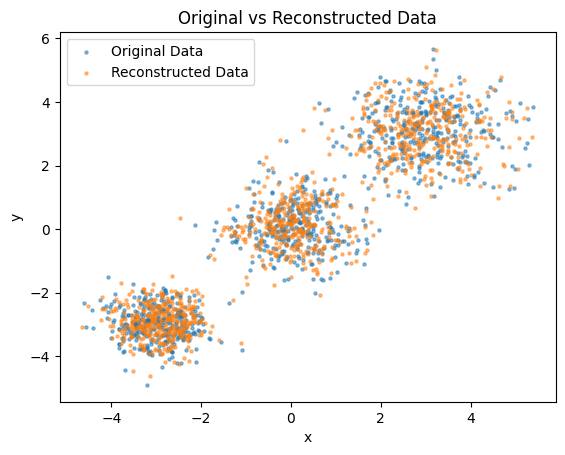

In [23]:
# Visualize reconstruction
with torch.no_grad():
    x_recon, _, _ = vae(X_tensor)

# Plot original vs reconstructed
plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.5, label="Original Data")
plt.scatter(x_recon.numpy()[:, 0], x_recon.numpy()[:, 1], s=5, alpha=0.5, label="Reconstructed Data")
plt.legend()
plt.title("Original vs Reconstructed Data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## 7. Generate New Samples

Sample points from a **standard normal distribution**, pass them through the **decoder**, and visualize the results.
This checks if the VAE has learned a meaningful latent space for generating new data.

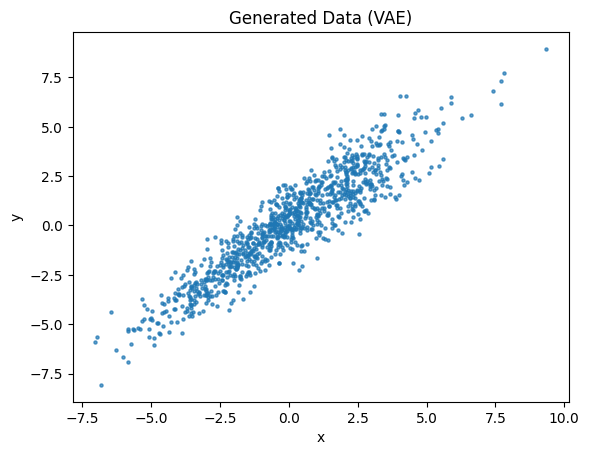

In [24]:
# Generate new samples from the latent space
with torch.no_grad():
    z = torch.randn(1000, latent_dim)  # Sample from standard normal distribution
    generated_data = vae.decoder(z).numpy()

# Visualize generated data
plt.scatter(generated_data[:, 0], generated_data[:, 1], s=5, alpha=0.7)
plt.title("Generated Data (VAE)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Resources

- Kingma, Diederik P. "[Auto-encoding variational bayes.](https://arxiv.org/abs/1312.6114)" (2013).